**Link trang web app :** https://share.streamlit.io/hiendang7613/ds_fakenewdetectionweb_project3/main/streamlit.py
<br>**Link code đầy đủ model và file VnCoreNLP-1.1.1.jar :** https://github.com/hiendang7613/DS_FakeNewDetectionWeb_Project3

# Đồ án 3 - Fake news detection

Thành viên : 

Đặng Văn Hiển - 18120363

Trà Anh Toàn - 1812662

Lê Thanh Viễn - 18120647

Nguyễn Trần Nhật Minh - 18120208

Nguyễn Vinh Quang - 18120229



# Import

In [1]:
import pandas as pd  # Hỗ trợ Dataframe 
from vncorenlp import VnCoreNLP # Hỗ trợ tokenize tiêng việt n-gram
import re # Loại bỏ kí tự đặc biệt
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
#Decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
# Model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import GradientBoostingClassifier
# Đánh giá mô hình
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
# Trực quan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
set_config(display='diagram') 

import time # Tính thời gian
import pickle # Lưu object
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Load thư viện hỗ trợ word-segment tiếng việt 
annotator = VnCoreNLP("VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx2g') 

# Tiền xử lý tập dữ liệu

## Đọc file

In [3]:
news_df = pd.read_csv('vn_news_223_tdlfr.csv')
news_df.head()

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1


### **Dữ liệu có bao nhiêu dòng và bao nhiêu cột?**

In [4]:
news_df.shape

(223, 3)

Vậy tập news_df có 223 dòng và 3 cột

### **Dữ liệu thiếu không ?**

In [5]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    223 non-null    object
 1   domain  223 non-null    object
 2   label   223 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.4+ KB


Không có dữ liệu thiếu ở các cột

## **Xử lý các dòng**

####  **Dữ liệu có các dòng bị lặp không?**

In [6]:
news_df.duplicated().sum()

1

Tập news_df có 1 dòng lặp. Ta tiến hành loại bỏ dòng lặp

In [7]:
news_df.drop_duplicates();

#### **Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?**

Mỗi dòng cho biết dữ liệu các bài báo và domain name của nó. <br> 
Không có vấn đề các dòng có ý nghĩa khác nhau.

## **Xử lý các cột**

#### **Mỗi cột có ý nghĩa gì?**

|Thuộc tính|Kiểu dữ liệu| Ý nghĩa |
|:---:|:---:|:---:|
|text|string|nội dung bài báo|
|domain|string|tên miền bài báo|
|label|boolean|nhãn phân loại tin giả (1) hay thật (0)|

#### **Kiểu dữ liệu hiện tại mỗi cột**

In [8]:
news_df.label.unique() # Kiểm tra miền dữ liệu ouput

array([1, 0], dtype=int64)

In [9]:
news_df.dtypes

text      object
domain    object
label      int64
dtype: object

In [10]:
news_df.text = news_df.text.astype('string');
news_df.domain = news_df.domain.astype('string');
news_df.label = news_df.label.astype('bool');

Kiểu dữ liệu các cột đều phù hợp. 

#### **Kiểm tra phân bố cột output**

In [11]:
# Cột output có bao nhiêu giá trị thiếu?
news_df['label'].isna().sum()

0

False    55.156951
True     44.843049
Name: label, dtype: float64

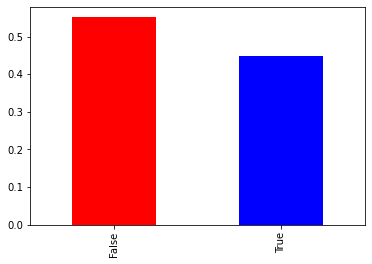

In [12]:
# Tỉ lệ các lớp trong cột output?
news_df.label.value_counts(normalize=True).plot(kind="bar", color=["red", "blue"])
news_df['label'].value_counts(normalize=True) * 100

Tỉ lệ giữa các giá trị cột output khá cân bằng

#### **Tách tập huấn luyện và kiểm thử**

In [13]:
# Tách X và y
y_sr = news_df["label"] 
X_df = news_df.drop("label", axis=1)

In [14]:
# Tách tập huấn luyện và tập validation theo tỉ lệ 80%:20%
train_X_df, test_X_df, train_y_sr, test_y_sr = train_test_split(X_df, y_sr, test_size=0.2, stratify=y_sr, random_state=9)

# Tiền xử lý ngôn ngữ

Tiền xử lý ngôn ngữ tiêng việt:
*   Word Embedding : N-grams Vectorization
*   Loại bỏ ký tự đặc biệt
*   Chuẩn hoá sang chữ thường
*   Chuẩn hoá sang chữ thường
*   Loại bỏ stop word

In [15]:
# Xử lý cột text
class PreprocessText(BaseEstimator, TransformerMixin):
    def __init__(self):
      self.pattern = "[^a-z0-9A-Z_ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚĂĐĨŨƠàáâãèéêìíòóôõùúăđĩũơƯĂẠẢẤẦẨẪẬẮẰẲẴẶẸẺẼỀỀỂưăạảấầẩẫậắằẳẵặẹẻẽềềểỄỆỈỊỌỎỐỒỔỖỘỚỜỞỠỢỤỦỨỪễệỉịọỏốồổỗộớờởỡợụủứừỬỮỰỲỴÝỶỸửữựỳỵỷỹ ]*"
      with open("vietnamese-stopwords.txt",encoding="utf-8") as f :
        self.stop_word = f.read().splitlines()
      return

    def fit(self, X_df, y=None):
      return self
      
    def transform(self, X_df, y=None):
      data = []
      for text in X_df['text']:
        # Chuẩn hoá cột text
        # 1.Loại bỏ ký tự đặc biệt
        text = re.sub(self.pattern, '',text)
        # 2.Tách từ
        text = annotator.tokenize(text)
        # 3.Loại bỏ stop_word
        text = [word for word in text[0] if word not in self.stop_word]
        # 4.Chuẩn hoá chữ thường
        text = [word.lower() for word in text]

        data.append(text)
      return pd.DataFrame({'text':data})

In [16]:
# Xử lý cột domain (thêm secret để tạo đặc trưng độc lập với cột text)
class PreprocessDomain(BaseEstimator, TransformerMixin):
    def __init__(self):
      self.secret = '$&#'
      return

    def fit(self, X_df, y=None):
      return self
      
    def transform(self, X_df, y=None):
      data = []
      for domain in X_df['domain']:
        # Chuẩn hoá cột domain
        # 1.Loại bỏ ký tự đặc biệt
        domain = domain.replace('.', ' ')
        # 2.Tách từ
        domain = annotator.tokenize(domain)
        # 3.Chuẩn hoá chữ thường
        domain = [word.lower() for word in domain[0]]
        # 4.Chuẩn hoá chữ thường
        domain = [word + self.secret for word in domain]
        data.append(domain)
      return pd.DataFrame({'domain':data})

In [17]:
class MergeCol(BaseEstimator, TransformerMixin):
    def __init__(self):
      return
    def fit(self, X_df, y=None):
      return self
    def transform(self, X_df, y=None):
      return [x[0]+x[1] for x in X_df]

# Tạo Pipeline

**Preprocessor pipeline**

In [18]:
colTransformer = ColumnTransformer(transformers=[  # Xử lý cột
  ('text', PreprocessText(), ['text']),
  ('domain', PreprocessDomain(), ['domain'])])
preprocessor = make_pipeline(colTransformer, MergeCol())

**Vectorizer pipeline**

In [19]:
def dummy(x): return x
vectorizer = make_pipeline(
    CountVectorizer(tokenizer=dummy,lowercase= False), # Count and vectorizer
    TfidfTransformer()) #Tfidf

**Decomposor pipeline**

In [20]:
decomposors = {
    'grp' : GaussianRandomProjection(),
    'tsvd' : TruncatedSVD(n_components=180), #best n_components GridSearchCV
    '' : FunctionTransformer(dummy), # skip decomposors
    }
decomposor = make_pipeline(decomposors['tsvd'])

**Model pipeline**

Các siêu tham số tốt được chọn ra thông qua GridSearchCV

In [21]:
models = {
    'lgr' : LogisticRegression(penalty= 'l2', C=20, solver='newton-cg'),
    'rfc' : RandomForestClassifier(class_weight = 'balanced_subsample',n_estimators= 200,max_features='auto',max_depth=30),
    'mnb' : MultinomialNB(alpha=0.2),
    'svc' : SVC(C=7, gamma='scale', kernel='sigmoid', verbose=True, probability=True), 
    'gbc' : GradientBoostingClassifier(n_estimators=5, learning_rate= 0.08, verbose=True, max_features='auto'),
    'pac' : PassiveAggressiveClassifier(C = 0.03, loss= 'hinge', verbose=True, n_jobs=-1 ),
    }
model = make_pipeline(models['svc'])

**Full-pipeline**

In [22]:
pipeline = Pipeline([
     ('preprocessor', preprocessor),
     ('vectorizer', vectorizer),
     ('decomposor', decomposor),
     ('model', model)
])
pipeline # Trực quan cấu trúc chung của pipeline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('text',
                                                                   PreprocessText(),
                                                                   ['text']),
                                                                  ('domain',
                                                                   PreprocessDomain(),
                                                                   ['domain'])])),
                                 ('mergecol', MergeCol())])),
                ('vectorizer',
                 Pipeline(steps=[('countvectorizer',
                                  CountVectorizer(lowercase=False,
                                                  tokenizer=<function dummy at 0x000002A3DD23A820>)),
                                 ('tfidftransformer', TfidfTransformer())])),
                ('decomposor',
                 Pipeline(steps=[('truncatedsvd',
                                  TruncatedSVD(n_components=180))])),
                ('model',
                 Pipeline(steps=[('svc',
                                  SVC(C=7, kernel='sigmoid', probability=True,
                                      verbose=True))]))])

# Huấn luyện mô hình

In [23]:
!mkdir model # Tạo folder chứa model

A subdirectory or file model already exists.
Error occurred while processing: model.
A subdirectory or file model already exists.
Error occurred while processing: model.


In [24]:
for decomposor_c in decomposors:
  for model_c in models:

    # Naive bayes không decompose vì đặc trưng độc lập 
    if model_c == 'mnb' and decomposor_c == 'grp': continue 
    if model_c == 'mnb' and decomposor_c == 'tsvd': continue 
    # Gán decomposor và model vào pipeline
    decomposor.steps[0] = (decomposor_c, decomposors[decomposor_c])
    pipeline.steps[2] = ('decomposor', decomposor)
    model.steps[0] = (model_c, models[model_c])
    pipeline.steps[3] = ('model', model)

    # Train model
    start_time = time.time()  
    pipeline.fit(train_X_df, train_y_sr);
    print("Train : {model}_{decomposor} in {time} seconds".format(
        model = type(models[model_c]).__name__,
        decomposor = type(decomposors[decomposor_c]).__name__,
        time = (time.time() - start_time)))
    
    # Độ chính xác của mỗi model 
    score = pipeline.score(train_X_df, train_y_sr)
    print("> train accurancy : {accurancy}% \n".format(
        accurancy = score*100))
    
    # lưu mô hình 
    filename = 'model/' + model_c + '_' + decomposor_c + '.model'
    pickle.dump(pipeline, open(filename, 'wb'))

Train : LogisticRegression_GaussianRandomProjection in 8.95802903175354 seconds
> train accurancy : 100.0% 

Train : RandomForestClassifier_GaussianRandomProjection in 9.013152122497559 seconds
> train accurancy : 100.0% 

[LibSVM]Train : SVC_GaussianRandomProjection in 11.195126056671143 seconds
> train accurancy : 100.0% 

      Iter       Train Loss   Remaining Time 
         1           1.2630            0.97s
         2           1.1650            0.64s
         3           1.0750            0.40s
         4           0.9947            0.20s
         5           0.9302            0.00s
Train : GradientBoostingClassifier_GaussianRandomProjection in 9.680790185928345 seconds
> train accurancy : 98.87640449438202% 

-- Epoch 1
Norm: 0.60, NNZs: 4441, Bias: -0.540000, T: 178, Avg. loss: 0.968841
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1.17, NNZs: 4441, Bias: -0.896433, T: 356, Avg. loss: 0.851526
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 1.66, NNZs: 4441, Bias: -

> train accurancy : 100.0% 

Train : RandomForestClassifier_TruncatedSVD in 6.764029502868652 seconds
> train accurancy : 100.0% 

[LibSVM]Train : SVC_TruncatedSVD in 7.214610815048218 seconds
> train accurancy : 100.0% 

      Iter       Train Loss   Remaining Time 
         1           1.2425            0.04s
         2           1.1263            0.03s
         3           1.0256            0.02s
         4           0.9398            0.01s
         5           0.8619            0.00s
Train : GradientBoostingClassifier_TruncatedSVD in 6.436407566070557 seconds
> train accurancy : 96.06741573033707% 

-- Epoch 1
Norm: 0.60, NNZs: 178, Bias: -0.540000, T: 178, Avg. loss: 0.968744
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1.17, NNZs: 178, Bias: -0.846389, T: 356, Avg. loss: 0.851039
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 1.67, NNZs: 178, Bias: -0.740372, T: 534, Avg. loss: 0.787160
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 2.18, NNZs: 178, Bias: -0.6255

> train accurancy : 97.75280898876404% 

-- Epoch 1
Norm: 0.60, NNZs: 9924, Bias: -0.005400, T: 178, Avg. loss: 0.980925
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1.20, NNZs: 9924, Bias: -0.010800, T: 356, Avg. loss: 0.912474
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 1.81, NNZs: 9924, Bias: -0.016200, T: 534, Avg. loss: 0.844023
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 2.41, NNZs: 9924, Bias: -0.021600, T: 712, Avg. loss: 0.775573
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 3.01, NNZs: 9924, Bias: -0.027000, T: 890, Avg. loss: 0.707122
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 3.61, NNZs: 9924, Bias: -0.032400, T: 1068, Avg. loss: 0.638671
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 4.21, NNZs: 9924, Bias: -0.037696, T: 1246, Avg. loss: 0.570481
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 4.79, NNZs: 9924, Bias: -0.041896, T: 1424, Avg. loss: 0.504884
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 5.34, NNZs: 9924, B

# Đánh giá mô hình

In [25]:
res_dict = {}
for decomposor_c in decomposors:
  res_dict[decomposor_c] = {}
  for model_c in models:

    # Naive bayes không decompose vì đặc trưng độc lập
    if model_c == 'mnb' and decomposor_c == 'grp': continue 
    if model_c == 'mnb' and decomposor_c == 'tsvd': continue 
    filename = 'model/' + model_c + '_' + decomposor_c + '.model'
    pipeline = pickle.load(open(filename, 'rb')) # Load mô hình

    # Test model 
    pred_y_sr = pipeline.predict(test_X_df) # Dự đoán nhãn trong tập test
    # Evaluate
    acc = accuracy_score(test_y_sr,pred_y_sr)
    pre = precision_score(test_y_sr,pred_y_sr)
    rec = recall_score(test_y_sr,pred_y_sr)
    f1 = f1_score(test_y_sr,pred_y_sr)
    cm = confusion_matrix(test_y_sr, pred_y_sr)
    
    res = [acc, pre, rec, f1, cm]
    res_dict[decomposor_c][model_c] = res
    # Print accurrency
    print("{model}_{decomposor} ".format(
      model = type(models[model_c]).__name__,
      decomposor = type(decomposors[decomposor_c]).__name__))
    print("> Test accurancy : {accurancy}% \n".format(
        accurancy = acc*100))

LogisticRegression_GaussianRandomProjection 
> Test accurancy : 86.66666666666667% 

RandomForestClassifier_GaussianRandomProjection 
> Test accurancy : 71.11111111111111% 

SVC_GaussianRandomProjection 
> Test accurancy : 88.88888888888889% 

GradientBoostingClassifier_GaussianRandomProjection 
> Test accurancy : 55.55555555555556% 

PassiveAggressiveClassifier_GaussianRandomProjection 
> Test accurancy : 82.22222222222221% 

LogisticRegression_TruncatedSVD 
> Test accurancy : 91.11111111111111% 

RandomForestClassifier_TruncatedSVD 
> Test accurancy : 71.11111111111111% 

SVC_TruncatedSVD 
> Test accurancy : 93.33333333333333% 

GradientBoostingClassifier_TruncatedSVD 
> Test accurancy : 80.0% 

PassiveAggressiveClassifier_TruncatedSVD 
> Test accurancy : 91.11111111111111% 

LogisticRegression_FunctionTransformer 
> Test accurancy : 91.11111111111111% 

RandomForestClassifier_FunctionTransformer 
> Test accurancy : 88.88888888888889% 

MultinomialNB_FunctionTransformer 
> Test accur

# Trực quan hoá

Heatmap các chỉ số đánh gia mô hình

In [26]:
# Tạo ma trận heatmap
mxt_dict = {}
mxt_dict['acc'] = []
mxt_dict['pre'] = []
mxt_dict['rec'] = []
mxt_dict['f1'] = []
mxt_dict['cm'] = []
for decomposor_c in decomposors:
  acc = []
  pre = []
  rec = []
  f1 = []
  cm = []
  for model_c in models:
    if model_c == 'mnb' and decomposor_c != '': 
      acc.append(np.nan)
      pre.append(np.nan)
      rec.append(np.nan)
      f1.append(np.nan)
      cm.append(np.nan)
      continue 
    acc.append(res_dict[decomposor_c][model_c][0])
    pre.append(res_dict[decomposor_c][model_c][1])
    rec.append(res_dict[decomposor_c][model_c][2])
    f1.append(res_dict[decomposor_c][model_c][3])
    cm.append(res_dict[decomposor_c][model_c][4])
  mxt_dict['acc'].append(acc)
  mxt_dict['pre'].append(pre)
  mxt_dict['rec'].append(rec)
  mxt_dict['f1'].append(f1)
  mxt_dict['cm'].append(cm)
  pass
# Nhãn ma trận
model_lb = ['LogisticRegression',
                 'RandomForestClassifier',
                 'MultinomialNB',
                 'SVC',
                 'GradientBoostingClassifier',
                 'PassiveAggressiveClassifier'] 
decomposor_lb = ['GaussianRandomProjection',
                 'TruncatedSVD',
                 'None'] 

## **Accuracy**

**Accuracy cho thấy khả năng mô hình gán đúng các nhãn**

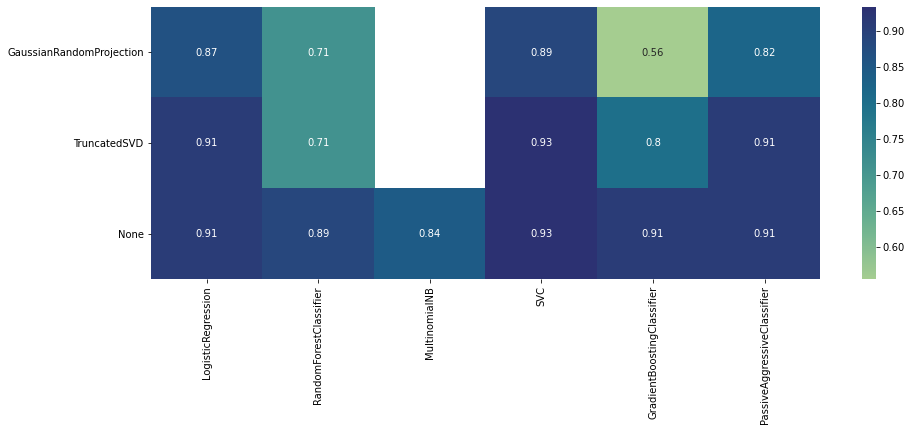

In [27]:
plt.subplots(figsize=(15, 5),)
sns.heatmap(mxt_dict['acc'],xticklabels=model_lb, yticklabels=decomposor_lb, cmap="crest", annot=True);

*   Mô hình SVC cho độ chính xác rất cao và có thể dùng tốt với các phương pháp giảm chiều.<br>
*   Tiếp theo là các mô hình PassiveAggressiveClassifier, LogisticRegression.<br>
*   RandomForestClassifier và GradientBoostingClassifier bị ảnh hưởng nhiều với phương pháp giảm chiều<br>
*   Multinomial Naive Bayes cho kết quả kém nhất và không dùng phương pháp giảm chiều vỉ các đặc trưng yêu cầu là biến cố độc lập

## **Precision**

**Precicison cao cho thấy mô hình ít nhận nhầm tin thật thành tin giả**

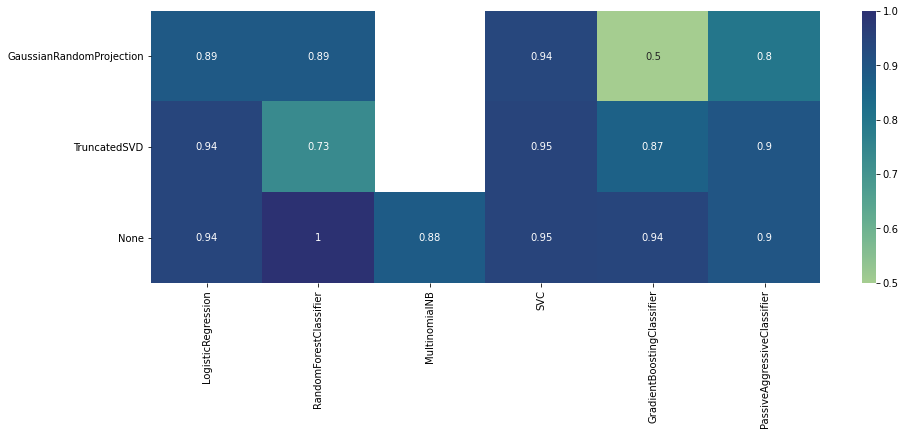

In [28]:
plt.subplots(figsize=(15, 5),)
sns.heatmap(mxt_dict['pre'],xticklabels=model_lb, yticklabels=decomposor_lb, cmap="crest", annot=True);

*  Các mô hình cho kết quả khá tốt ít nhận nhầm tin thật thành tin giả <br>
*  RandomForestClassifier và GradientBoostingClassifier bị ảnh hưởng nhiều với phương pháp giảm chiều, đặc biệt GradientBoostingClassifier dùng GaussianRandomProject cho kết quả rất xấu

## **Recall**

**Recall cao cho thấy mô hình ít bỏ sót tin giả**

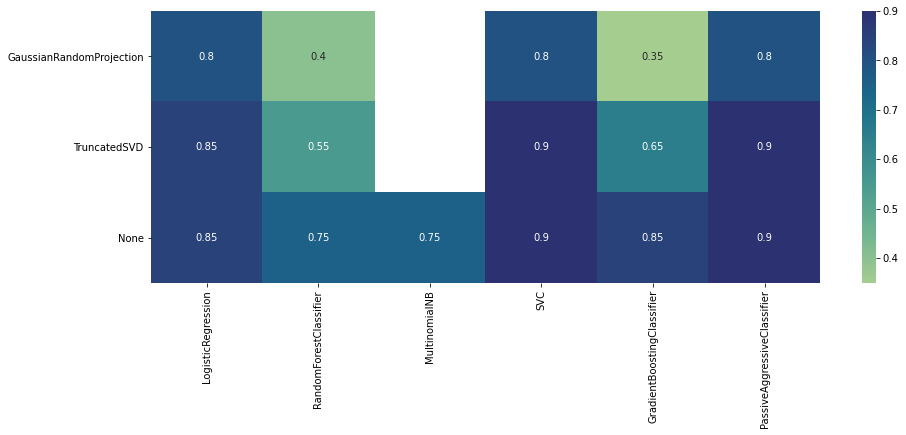

In [29]:
plt.subplots(figsize=(15, 5),)
sns.heatmap(mxt_dict['rec'],xticklabels=model_lb, yticklabels=decomposor_lb, cmap="crest", annot=True);

*  SVC và PassiveAggressiveClassifier vẫn cho kết quả khá tốt khi rất ít bỏ sát tin giả. <br>
*  RandomForestClassifier và GradientBoostingClassifier cho kết quả kém hơn và bị ảnh hưởng nhiều với phương pháp giảm chiều.

## **F1-score**

Trung hoà 2 tiêu chí trên của Recall và Precision

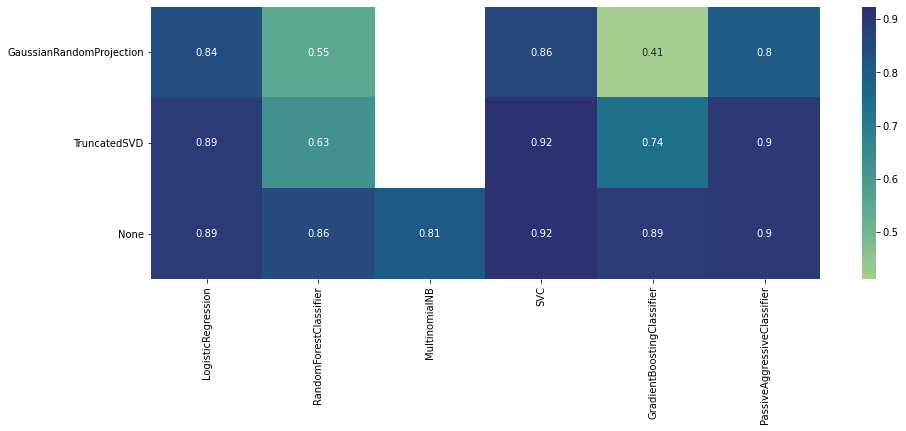

In [30]:
plt.subplots(figsize=(15, 5),)
sns.heatmap(mxt_dict['f1'],xticklabels=model_lb, yticklabels=decomposor_lb, cmap="crest", annot=True);

*   Mô hình SVC cho kết quả tốt nhất<br>
*   Tiếp theo là các mô hình PassiveAggressiveClassifier, LogisticRegression.<br>
*   RandomForestClassifier và GradientBoostingClassifier bị ảnh hưởng nhiều với phương pháp giảm chiều<br>
*   Multinomial Naive Bayes cho kết quả kém nhất.

## **Confusion matrix**

Ma trận trực quan số lượng mẫu True/False Positive/Negative

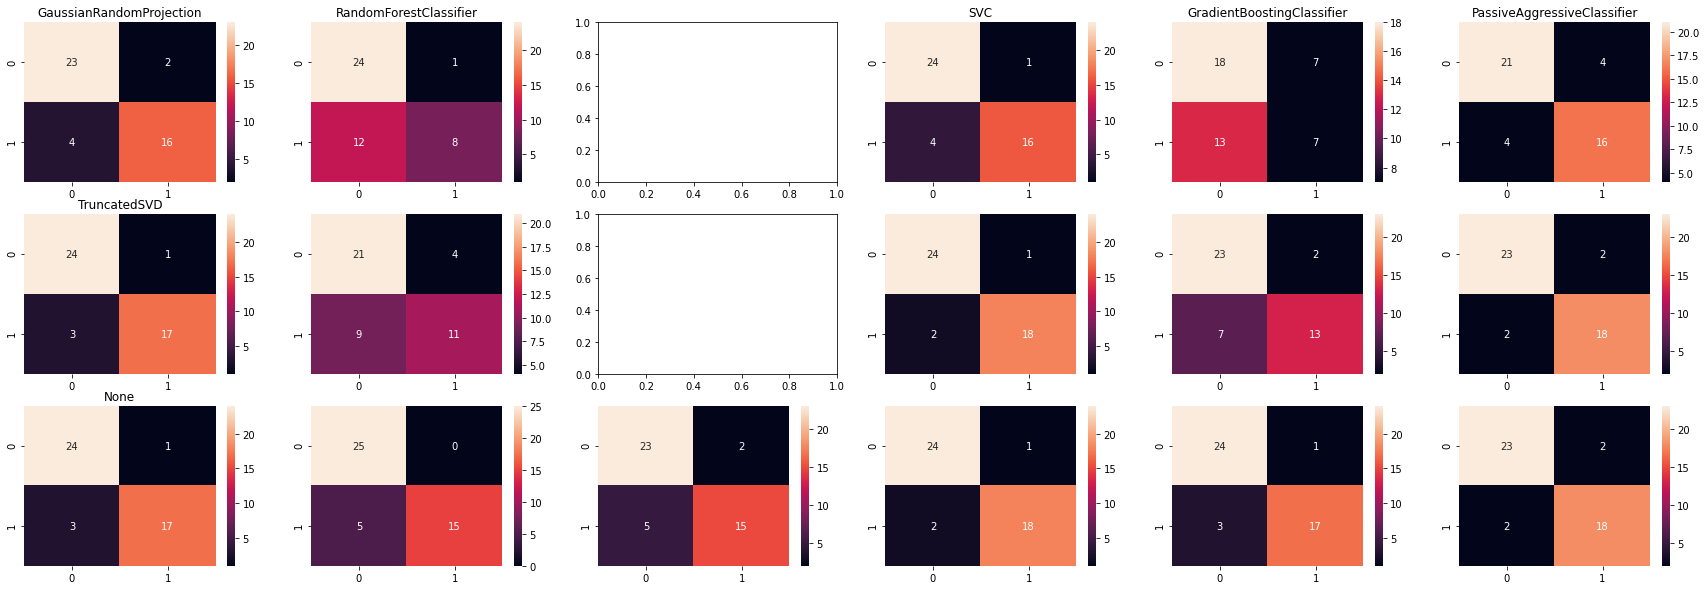

In [31]:
_, axs = plt.subplots(3,6, figsize=(30,10))

for decomposor_c in range(3):
  for model_c in range(6):
    cm = mxt_dict['cm'][decomposor_c][model_c]
    if type(cm) != np.ndarray: continue 
    if decomposor_c == 0: 
      axs[decomposor_c,model_c].set_title(model_lb[model_c])
    if model_c == 0: 
      axs[decomposor_c,model_c].set_title(decomposor_lb[decomposor_c])
    axs[decomposor_c,model_c].set_xlabel('Predicted labels');
    axs[decomposor_c,model_c].set_ylabel('True labels'); 
    axs[decomposor_c,model_c].xaxis.set_ticklabels(['Negative', 'Positive']); 
    axs[decomposor_c,model_c].yaxis.set_ticklabels(['Negative', 'Positive']);
    f = sns.heatmap(cm, annot=True, ax = axs[decomposor_c,model_c])